In [1]:
!pip install datasets accelerate bitsandbytes trl peft -U -q

In [2]:
import numpy as np
import pandas as pd

import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, BitsAndBytesConfig, DataCollatorForLanguageModeling
import bitsandbytes as bnb
from trl import SFTTrainer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import datasets
from accelerate import Accelerator

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
dataset = datasets.load_dataset('flytech/llama-python-codes-30k', split='train')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
dataset

Dataset({
    features: ['instruction', 'input', 'output', 'text'],
    num_rows: 27332
})

In [5]:
# FOR TEST THE TRAINING (get rid of it if you want to train a model on a full data)
shuffled_dataset = dataset.shuffle(seed=42)
subset_size = int(0.05 * len(shuffled_dataset)) # 5% от исходного датасета
subset = shuffled_dataset.select(range(subset_size))
subset

Dataset({
    features: ['instruction', 'input', 'output', 'text'],
    num_rows: 1366
})

## count max_length of our tokenized_data

In [6]:
model_name = 'NousResearch/Llama-2-7b-chat-hf'
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True,
                                          add_eos_token=True, add_bos_token=True)

In [7]:
def tokenize(example):
  prompt = f"Question: {example['instruction']}\n Answer: {example['output']}"
  result = tokenizer(prompt)
  result['labels'] = result['input_ids'].copy()
  return result

In [8]:
subset_tokenizer_for_getting_max_length = subset.map(tokenize)

Map:   0%|          | 0/1366 [00:00<?, ? examples/s]

In [9]:
tokenizer.decode(subset_tokenizer_for_getting_max_length['input_ids'][0])

"<s> Question: [INST]Execute code: from flask import Flask\napp = Flask(__name__)\n\n@app.route('/')\ndef hello_world():\n    return 'Hello, World!'\n\nif __name__ == '__main__':\n    app.run()[/INST]\n Answer: ```python\nfrom flask import Flask\napp = Flask(__name__)\n\n@app.route('/')\ndef hello_world():\n    return 'Hello, World!'\n\nif __name__ == '__main__':\n    app.run()\n# Code executed.\n```</s>"

In [10]:
len(subset_tokenizer_for_getting_max_length['input_ids'][0])

135

In [11]:
maxi = 0
for i in range(len(subset_tokenizer_for_getting_max_length)):
  maxi = max(maxi, len(subset_tokenizer_for_getting_max_length['input_ids'][i]))
maxi

497

1366


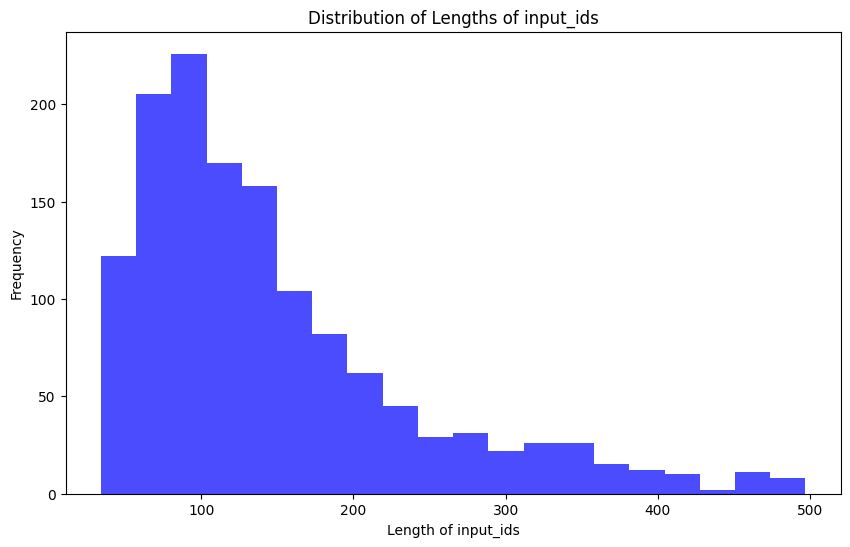

In [12]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(subset_tokenizer_for_getting_max_length)

## continue

In [13]:
max_length = 497 # we found it out above

model_name = 'NousResearch/Llama-2-7b-chat-hf'
tokenizer = AutoTokenizer.from_pretrained(
    model_name, padding_side='left',
    add_eos_token=True, add_bos_token=True
)
tokenizer.pad_token = tokenizer.eos_token

def formatting_func(example):
    prompt = f"Question: {example['instruction']}\n Answer: {example['output']}"
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [14]:
subset = subset.map(formatting_func)

In [15]:
new_dataset = subset.train_test_split(test_size=0.2)
train_dataset, eval_dataset = new_dataset['train'], new_dataset['test']
train_dataset, eval_dataset

(Dataset({
     features: ['instruction', 'input', 'output', 'text', 'input_ids', 'attention_mask', 'labels'],
     num_rows: 1092
 }),
 Dataset({
     features: ['instruction', 'input', 'output', 'text', 'input_ids', 'attention_mask', 'labels'],
     num_rows: 274
 }))

In [16]:
tokenizer.decode(train_dataset['input_ids'][4])

'</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s

## Let's check how base model deal with it first (before fine-tuning)

In [17]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True
)

In [18]:
model_name = 'NousResearch/Llama-2-7b-chat-hf'
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map='auto',
    low_cpu_mem_usage=True, offload_state_dict=True
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
print("Question: " + train_dataset[0]['instruction'])
print("Answer: " + train_dataset[0]['output'] + "\n")

Question: [INST]Create an expression parser in Python to evaluate basic mathematical expressions[/INST]
Answer: ```python
# Assume input is a valid mathematical expression with no syntax errors 

def expression_parser(expression): 
    tokens = expression.split() 
    stack = [] 
  
    for token in tokens: 
        if token == '+' or token == '*' or token == '/': 
            a = stack.pop() 
            b = stack.pop() 
            if token == '+': 
                c = b + a 
            elif token == '*': 
                c = b * a 
            else: 
                c = b / a 
            stack.append(c) 
        else: 
            stack.append(int(token)) 
    return stack.pop()
```



In [13]:
eval_prompt = f"Question: {train_dataset[0]['instruction']}\n Answer: "

In [14]:
eval_tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    add_bos_token=True
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256)[0], skip_special_tokens=True))

Question: [INST]Create an expression parser in Python to evaluate basic mathematical expressions[/INST]
 Answer: 

Creating an expression parser in Python to evaluate basic mathematical expressions can be done using a combination of regular expressions and a dictionary of mathematical operators. Here is an example implementation:

First, define a dictionary of mathematical operators and their associated functions:
```
operators = {
    '+': lambda x, y: x + y,
    '-': lambda x, y: x - y,
    '*': lambda x, y: x * y,
    '/': lambda x, y: x / y,
    '//': lambda x, y: x // y,
    '**': lambda x, y: x ** y,
}
```
Next, define a regular expression to match mathematical expressions:
```
expression_regex = r'[+\-*\/]?([0-9]+([\+\-*\/]?[0-9])?)'
```
This regular expression matches any sequence of digits, optional operators, and optional more digits. The `?` flag makes the operator optional, and the `([0-9]+` part matches one or more digits.

Now, you can define a function to parse and evalu

## Getting LoRA and fine-tune

In [19]:
model.gradient_checkpointing_enable()
#model.enable_input_require_grads()
model = prepare_model_for_kbit_training(model)

In [20]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [21]:
import re
def get_num_layers(model):
    numbers = set()
    for name, _ in model.named_parameters():
        for number in re.findall(r'\d+', name):
            numbers.add(int(number))
    return max(numbers)

def get_last_layer_linears(model):
    names = []

    num_layers = get_num_layers(model)
    for name, module in model.named_modules():
        if str(num_layers) in name and not "encoder" in name:
            if isinstance(module, torch.nn.Linear):
                names.append(name)
    return names

In [22]:
get_num_layers(model)

31

In [23]:
get_last_layer_linears(model)

['model.layers.31.self_attn.q_proj',
 'model.layers.31.self_attn.k_proj',
 'model.layers.31.self_attn.v_proj',
 'model.layers.31.self_attn.o_proj',
 'model.layers.31.mlp.gate_proj',
 'model.layers.31.mlp.up_proj',
 'model.layers.31.mlp.down_proj']

In [24]:
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=get_last_layer_linears(model), # only_last_layer
    #[   "q_proj", # all_layers
    #    "k_proj",
    #    "v_proj",
    #    "o_proj",
    #    "gate_proj",
    #    "up_proj",
    #    "down_proj",
    #    "lm_head",
    #],
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

accelerator = Accelerator()
model = accelerator.prepare_model(model)

trainable params: 624640 || all params: 3501037568 || trainable%: 0.017841568045693132


In [ ]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb.init(project="llama2-code-fine-tune", name="1")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: danilka200300 (danilka200300-misis). Use `wandb login --relogin` to force relogin


In [21]:
if torch.cuda.device_count() > 1:
    model.is_parallelizable = True
    model.model_parallel = True

In [25]:
collate_fn = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [26]:
project = "llama2-code-fine-tune"
base_model_name = "llama2-7b"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

training_args = TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=8,
        gradient_checkpointing=True,
        gradient_accumulation_steps=1,
        max_steps=1000,
        learning_rate=2.5e-5,
        logging_steps=25,
        bf16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",
        save_strategy="steps",
        save_steps=25,
        eval_strategy="steps",
        eval_steps=25,
        do_eval=True,
        report_to="wandb",
    )

In [27]:
max_length = 497 # we found it out above
tokenizer.pad_token = tokenizer.eos_token

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=config,
    args=training_args,
    data_collator=collate_fn,
    max_seq_length=max_length
)

model.config.use_cache = False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:408: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in

In [28]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

## THROW AWAY (BUT USEFUL INFO CAN BE FOUND HERE TOO)

In [ ]:
def formatting_func(example):
  return {'text': f"Question: {example['instruction']}\n Answer: {example['output']}"}

In [ ]:
#dataset = dataset.map(formatting_func)
subset = subset.map(formatting_func)

Map:   0%|          | 0/1366 [00:00<?, ? examples/s]

In [ ]:
#dataset['text'][0]

"<s>[INST]Help me set up my daily to-do list![/INST] Setting up your daily to-do list... ```python\ntasks = []\nwhile True:\n    task = input('Enter a task or type 'done' to finish: ')\n    if task == 'done': break\n    tasks.append(task)\nprint(f'Your to-do list for today: {tasks}')\n```</s>"

In [ ]:
subset['text'][0]

"Question: [INST]Execute code: from flask import Flask\napp = Flask(__name__)\n\n@app.route('/')\ndef hello_world():\n    return 'Hello, World!'\n\nif __name__ == '__main__':\n    app.run()[/INST]\n Answer: ```python\nfrom flask import Flask\napp = Flask(__name__)\n\n@app.route('/')\ndef hello_world():\n    return 'Hello, World!'\n\nif __name__ == '__main__':\n    app.run()\n# Code executed.\n```"

In [ ]:
new_dataset = subset.train_test_split(test_size=0.2) #dataset.train_test_split(test_size=0.2)
new_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'text'],
        num_rows: 1092
    })
    test: Dataset({
        features: ['instruction', 'input', 'output', 'text'],
        num_rows: 274
    })
})

In [ ]:
train_dataset, eval_dataset = new_dataset['train'], new_dataset['test']
train_dataset, eval_dataset

(Dataset({
     features: ['instruction', 'input', 'output', 'text'],
     num_rows: 1092
 }),
 Dataset({
     features: ['instruction', 'input', 'output', 'text'],
     num_rows: 274
 }))

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True
)

In [ ]:
model_name = 'NousResearch/Llama-2-7b-chat-hf'
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map={"": 0}
)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.padding_side = 'left'

In [ ]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.1,
    bias='none',
    task_type='CAUSAL_LM'
)

In [ ]:
pip install wandb -q

In [ ]:
!wandb login

In [ ]:
import wandb
wandb.init(project="llama2-code-fine-tune", name="1")

wandb: Currently logged in as: danilka200300 (danilka200300-misis). Use `wandb login --relogin` to force relogin


In [ ]:
training_args = TrainingArguments(
    output_dir='./output',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    gradient_checkpointing=True,
    gradient_accumulation_steps=1,
    learning_rate=3e-4,
    optim='paged_adamw_32bit',
    weight_decay=0.001,
    warmup_ratio = 0.03,
    group_by_length = True,
    lr_scheduler_type = "cosine",
    max_steps = -1,
    max_grad_norm=0.3,
    log_level="info",
    disable_tqdm=False,

    report_to="wandb",
    eval_steps=1,
    logging_steps=1,
    do_eval=True,
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=3
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices


In [ ]:
### NEED TO DEAL WITH THIS PROBLEM WITH 'Answer: ' not found and model unability to calculate loss
train_dataset['text'][0]

'Question: [INST]How to do sentiment analysis on news articles?[/INST]\n Answer: ```python\n# Doing sentiment analysis on news articles.\nfrom textblob import TextBlob\n# Scrape news articles.\n# Use TextBlob to analyze the sentiment of the article.\n```'

In [ ]:
for i in range(len(train_dataset)):
  print(train_dataset['text'][i])
  break

In [ ]:
template='Answer: '
collate_fn = DataCollatorForCompletionOnlyLM(response_template=template, tokenizer=tokenizer)

In [ ]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=peft_config,
    args=training_args,
    max_seq_length=2048,
    data_collator=collate_fn,
    packing=False
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTra

AttributeError: 'list' object has no attribute 'column_names'

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 1,092
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 137
  Number of trainable parameters = 8,388,608
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:187: UserWarning: Could not find response key `Answer: ` in the following instance: <s> Question: [INST]Implement a Binary Search Tree (BST) in Python. The BST should have  methods for insertion, search and traversal[/INST]
 Answer: ```python
class Node:
 def __init__(self, data):
 self.left = None
 self.right = None
 self.data = data

    
class BST:
 def __init__(self):
 self.root = None
 
 def insert(self, data):
 if self.root == None:
 self.root = Node(data)
 else:
 self._insert(data, self.root)
 
 def _insert(self, data, curr_node):
 if 

KeyboardInterrupt: 